# Generation of Fake Data

In [17]:
import pandas as pd
from copy import deepcopy
from random import randint

data= {
  'uid': [],
  'qsol':[],  
}

qData= {
    'qid':[],
    'time':[],
    'vote':[],
    'isol':[]
  }

for uid in range(0,1000):
    
    data['uid'].append(uid)
    temp= deepcopy(qData)
    
    for qid in range(0,6000):
        temp['qid'].append(qid)
        rn_time= randint(0,3600*24)
        rn_vote= randint(0,1)
        rn_isol= randint(0,1)
        
        temp['time'].append(rn_time)
        temp['vote'].append(rn_vote)
        temp['isol'].append(rn_isol)
    data['qsol'].append(temp)

df= pd.DataFrame(data)
df

,uid,qsol
0,0,"{'qid': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
1,1,"{'qid': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
2,2,"{'qid': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
3,3,"{'qid': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
4,4,"{'qid': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
...,...,...
995,995,"{'qid': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
996,996,"{'qid': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
997,997,"{'qid': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
998,998,"{'qid': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random
import gc
from tqdm import tqdm
import matplotlib as plt

# Setting a seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
def prepare_data(synthetic_data:pd.DataFrame):
    user_ids = []
    question_ids = []
    question_features = []
    ratings = []

    # Normalization factor for 'time'
    max_time = 3600 * 24

    for ind, record in synthetic_data.iterrows():
        uid = record['uid']; n= len( record['qsol']['qid'] )
        qsol= record['qsol']
        for i in range(n):
            user_ids.append(uid)
            question_ids.append(qsol['qid'][i])
            normalized_time = qsol['time'][i] / max_time
            vote = qsol['vote'][i]
            issol = qsol['isol'][i]
            question_features.append([normalized_time, vote, issol])
            ratings.append(vote)
    
    user_ids = np.array(user_ids)
    question_ids = np.array(question_ids)
    question_features = np.array(question_features, dtype=np.float32)
    ratings = np.array(ratings, dtype=np.float32)
    
    return user_ids, question_ids, question_features, ratings

user_ids, question_ids, question_features, ratings = prepare_data(df)
del df
gc.collect()

0

In [20]:
# Splitting the data
train_user_ids, test_user_ids, train_question_ids, test_question_ids, train_features, test_features, train_ratings, test_ratings = train_test_split(
    user_ids, question_ids, question_features, ratings, test_size=0.2, random_state=42
)

# Split the training set further for validation
train_user_ids, val_user_ids, train_question_ids, val_question_ids, train_features, val_features, train_ratings, val_ratings = train_test_split(
    train_user_ids, train_question_ids, train_features, train_ratings, test_size=0.2, random_state=42
)

class UserQuestionDataset(Dataset):
    def __init__(self, user_ids, question_ids, question_features, ratings):
        self.user_ids = user_ids
        self.question_ids = question_ids
        self.question_features = question_features
        self.ratings = ratings

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return (self.user_ids[idx],
                self.question_ids[idx],
                self.question_features[idx],
                self.ratings[idx])


In [21]:
class UserToUserRecommendationModel(nn.Module):
    def __init__(self, num_users, num_questions, feature_dim, embedding_dim):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.question_embedding = nn.Embedding(num_questions, embedding_dim)
        
        self.feature_layer = nn.Linear(feature_dim, embedding_dim)
        
        self.fc1 = nn.Linear(embedding_dim * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, user_ids, question_ids, question_features):
        # Look up embeddings
        user_emb = self.user_embedding(user_ids)
        question_emb = self.question_embedding(question_ids)
        question_feat_emb = self.feature_layer(question_features)
        
        x = torch.cat([user_emb, question_emb, question_feat_emb], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        score = torch.sigmoid(self.fc3(x)).squeeze()  # Sigmoid activation for binary output
        
        return score


In [24]:
num_users = max(user_ids) + 1
num_questions = max(question_ids) + 1
feature_dim = 3  # [normalized_time, vote, issol]
embedding_dim = 128  # Updated embedding dimension
batch_size = 64
num_epochs = 10
learning_rate = 0.001

# Dataloaders
train_dataset = UserQuestionDataset(train_user_ids, train_question_ids, train_features, train_ratings)
val_dataset = UserQuestionDataset(val_user_ids, val_question_ids, val_features, val_ratings)
test_dataset = UserQuestionDataset(test_user_ids, test_question_ids, test_features, test_ratings)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss Function, and Optimizer
model = UserToUserRecommendationModel(num_users, num_questions, feature_dim, embedding_dim).to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary prediction
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to track losses for plotting
train_losses = []
val_losses = []
test_losses = []  # New list for tracking test set loss

def train(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        # Training loop
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for user_ids, question_ids, question_features, ratings in progress_bar:
            user_ids = user_ids.long().to(device)
            question_ids = question_ids.long().to(device)
            question_features = question_features.float().to(device)
            ratings = ratings.float().to(device)

            optimizer.zero_grad()
            predictions = model(user_ids, question_ids, question_features)
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        
        avg_train_loss = total_loss / len(train_loader)
        
        # Validation after each epoch
        avg_val_loss = evaluate(model, val_loader, criterion)        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Evaluation Function (also used for validation and test)
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for user_ids, question_ids, question_features, ratings in data_loader:
            user_ids = user_ids.long().to(device)
            question_ids = question_ids.long().to(device)
            question_features = question_features.float().to(device)
            ratings = ratings.float().to(device)

            outputs = model(user_ids, question_ids, question_features)
            loss = criterion(outputs, ratings)
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

# Training the model
train(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs)

Epoch 1/10: 100%|██████████| 60000/60000 [02:20<00:00, 425.58it/s, loss=1.81e-13]


Epoch [1/10], Train Loss: 0.0002, Validation Loss: 0.0000


Epoch 2/10: 100%|██████████| 60000/60000 [02:23<00:00, 417.04it/s, loss=8.69e-14]


Epoch [2/10], Train Loss: 0.0000, Validation Loss: 0.0000


Epoch 3/10: 100%|██████████| 60000/60000 [02:31<00:00, 396.58it/s, loss=1.07e-13]


Epoch [3/10], Train Loss: 0.0000, Validation Loss: 0.0000


Epoch 4/10: 100%|██████████| 60000/60000 [02:24<00:00, 414.26it/s, loss=9.31e-14]


Epoch [4/10], Train Loss: 0.0000, Validation Loss: 0.0000


Epoch 5/10: 100%|██████████| 60000/60000 [02:20<00:00, 426.32it/s, loss=3.45e-14]


Epoch [5/10], Train Loss: 0.0000, Validation Loss: 0.0000


Epoch 6/10: 100%|██████████| 60000/60000 [02:22<00:00, 422.27it/s, loss=2.36e-14]


Epoch [6/10], Train Loss: 0.0000, Validation Loss: 0.0000


Epoch 7/10: 100%|██████████| 60000/60000 [02:21<00:00, 422.66it/s, loss=2.58e-14]


Epoch [7/10], Train Loss: 0.0000, Validation Loss: 0.0000


Epoch 8/10: 100%|██████████| 60000/60000 [02:19<00:00, 428.97it/s, loss=3.57e-14]


Epoch [8/10], Train Loss: 0.0000, Validation Loss: 0.0000


Epoch 9/10: 100%|██████████| 60000/60000 [02:21<00:00, 425.45it/s, loss=2e-14]   


Epoch [9/10], Train Loss: 0.0000, Validation Loss: 0.0000


Epoch 10/10: 100%|██████████| 60000/60000 [02:21<00:00, 425.31it/s, loss=1.94e-14]


Epoch [10/10], Train Loss: 0.0000, Validation Loss: 0.0000


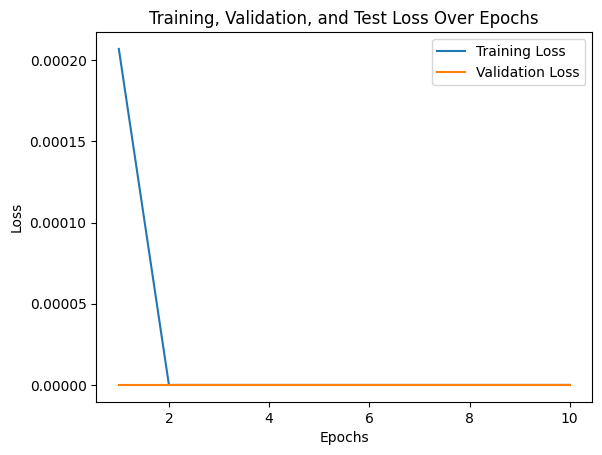

In [26]:
import matplotlib.pyplot as plt
 
plt.plot( range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot( range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.legend()
plt.show()

In [27]:
test_loss = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0000


In [28]:
# Save the model after training
torch.save(model.state_dict(), 'user_to_user_recommendation_model.pth')
print("Model saved to 'user_to_user_recommendation_model.pth'")

Model saved to 'user_to_user_recommendation_model.pth'


In [29]:
# Define the model architecture again
model = UserToUserRecommendationModel(num_users, num_questions, feature_dim, embedding_dim).to(device)
model.load_state_dict(torch.load('user_to_user_recommendation_model.pth'))
model.eval()

print("Model loaded from 'user_to_user_recommendation_model.pth'")

Model loaded from 'user_to_user_recommendation_model.pth'


/tmp/ipykernel_3462474/2693641886.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('user_to_user_recommendation_model.pth'))
